In [1]:
from tensorflow.keras.models import load_model
from tqdm import tqdm_notebook as tqdm
import mnist
import dnn
import os.path
import graph_tool as gt
import nn2graph
import numpy as np
import pandas as pd
import statsmodels.stats as stats
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skmetrics

#### Build or load model

In [2]:
load_saved_model = True
if load_saved_model and os.path.exists('data/outputs/mnist_dnn_4x64_10.h5'):
    model = load_model('data/outputs/mnist_dnn_4x64_10.h5')
else:
    model = dnn.build_dense(X_train.shape[-1], hidden_dims=64)
    model.fit(mnist.X_train, mnist.y_train, batch_size=128, epochs=10, validation_data=(mnist.X_test, mnist.y_test))
    model.save('data/outputs/mnist_dnn_4x64_10.h5')

In [3]:
print(model.evaluate(mnist.X_test, mnist.y_test, verbose=0))
y_pred = model.predict(mnist.X_test)

[2.2895871978759765, 0.0974]


#### Convert neural network to graph

In [4]:
from tensorflow.keras.layers import Dense
N = 100
rand_inds = mnist.subsample_test(N)
layer_sizes = [mnist.X_test.shape[-1]] + [layer.units for layer in model.layers if isinstance(layer, Dense)]
g_full, g_xs = nn2graph.dense_activations_to_graph(model, mnist.X_test[rand_inds])

In [5]:
def fit_sbm(g):
    from graph_tool.inference.minimize import minimize_nested_blockmodel_dl
    bs = g.vp.layer.a
    return minimize_nested_blockmodel_dl(g)
    
def fit_weighted_sbm(g):
    from graph_tool.inference.minimize import minimize_nested_blockmodel_dl
    bs = g.vp.layer.a
    return minimize_nested_blockmodel_dl(g, bs=[bs], state_args=dict(recs=[g.ep.activation], rec_types=['real-normal']))

In [6]:
sbms = [fit_sbm(g) for g in tqdm(g_xs)]

/home/brian/anaconda3/envs/networks/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [22]:
sbms = np.load('data/outputs/sbm/nested_sbm_1.dat', allow_pickle=True)

In [10]:
np.save('data/outputs/sbm/nested_sbm_1.dat', sbms)

In [23]:
bss_l0 = [np.array(sbm.get_bs()[0], dtype=np.float32) for sbm in sbms]

In [52]:
nmi = np.zeros((len(bss_l0),len(bss_l0)))
for i, bs_i in enumerate(bss_l0):
    for j, bs_j in enumerate(bss_l0):
        nmi[i,j] = skmetrics.normalized_mutual_info_score(bs_i, bs_j, average_method='arithmetic')

In [53]:
nmi_per_class = np.zeros((10,10))
for i in range(10):
    for j in range(0, i+1):
        nmi_per_class[i,j] = np.mean(nmi[i*10:(i+1)*10,j*10:(j+1)*10])

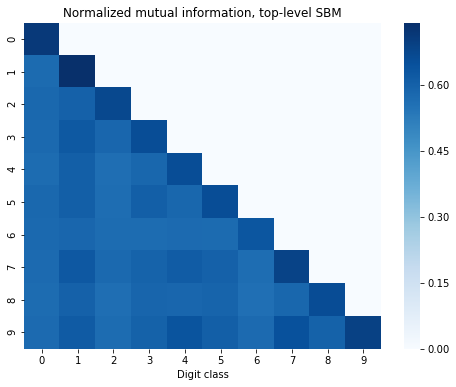

In [59]:
plt.figure(figsize=(8,6))
sns.heatmap(nmi_per_class, cmap='Blues')
plt.title('Normalized mutual information, top-level SBM')
plt.xlabel('Digit class')
plt.show()

In [64]:
n = nmi_per_class.shape[0]
print('average NMI in-class: {:.2f}'.format(np.mean(np.diag(nmi_per_class))))
print('average NMI between-class: {:.2f}'.format(np.sum(np.tril(nmi_per_class, k=-1)) / (n*(n-1) / 2)))

average NMI in-class: 0.68
average NMI between-class: 0.59


In [6]:
sbm = fit_weighted_sbm(g_xs[0])

In [7]:
sbm.print_summary()

l: 0, N: 1050, B: 299
l: 1, N: 299, B: 149
l: 2, N: 149, B: 92
l: 3, N: 92, B: 11
l: 4, N: 11, B: 2
l: 5, N: 2, B: 1


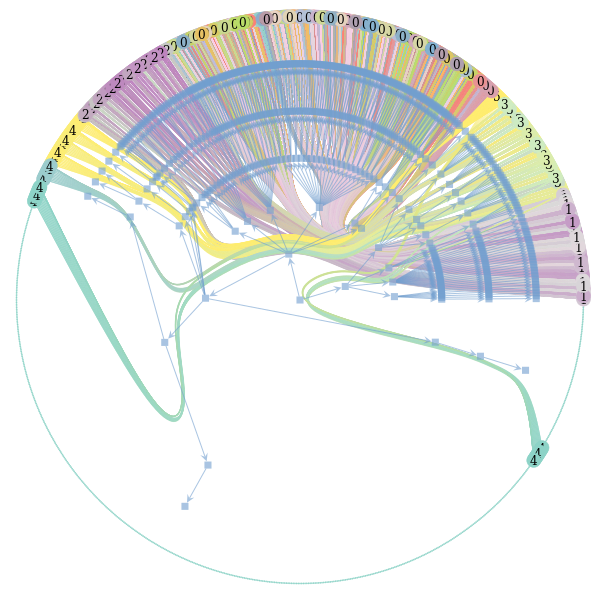

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb41808dbe0, at 0x7fb4a51fb860>,
 <Graph object, directed, with 1604 vertices and 1603 edges at 0x7fb4a502fa20>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb4a502fa20, at 0x7fb4a4fc0780>)

In [31]:
sbm.draw(
        vprops={
    'text': g_xs[0].new_vp('string', vals=[str(l) if d > 0 else '' for i, (l, d) in enumerate(zip(g_xs[0].vp.layer.a, g_xs[0].vp.degree.a))])
})

In [24]:
sbm_0 = fit_sbm(g_xs[0])

/home/brian/anaconda3/envs/networks/lib/python3.6/site-packages/graph_tool/draw/cairo_draw.py:637: UserWarning: Unknown parameter: font_size
  warnings.warn("Unknown parameter: " + k, UserWarning)
/home/brian/anaconda3/envs/networks/lib/python3.6/site-packages/graph_tool/draw/cairo_draw.py:637: UserWarning: Unknown parameter: text_position
  warnings.warn("Unknown parameter: " + k, UserWarning)


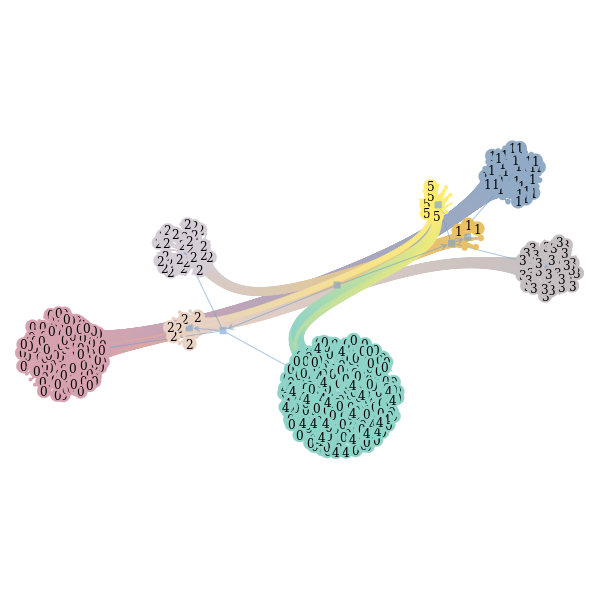

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb41808dbe0, at 0x7fb4a5296b00>,
 <Graph object, directed, with 1061 vertices and 1060 edges at 0x7fb4a50f9940>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb4a50f9940, at 0x7fb4a52b5f98>)

In [25]:
sbm_0.draw(vprops={
    'text': g_xs[0].new_vp('string', vals=[str(l) if i % 2 == 0 else '' for i, l in enumerate(g_xs[0].vp.layer.a)])
}, layout='sfdp', font_size=6, text_position=np.pi/2)

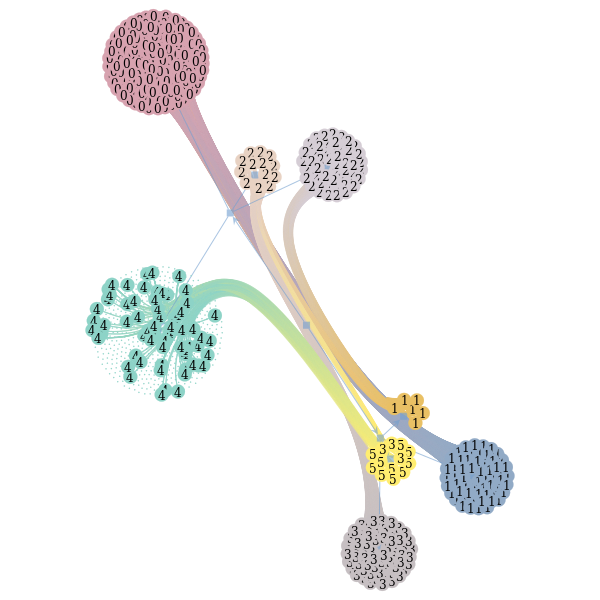

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb41808dbe0, at 0x7fb4a574be48>,
 <Graph object, directed, with 1061 vertices and 1060 edges at 0x7fb4a574bb70>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb4a574bb70, at 0x7fb4a5023c50>)

In [28]:
sbm_0.draw(vprops={
    'text': g_xs[0].new_vp('string', vals=[str(l) if d > 0 else '' for i, (l, d) in enumerate(zip(g_xs[0].vp.layer.a, g_xs[0].vp.degree.a))])
}, layout='sfdp', font_size=6, text_position=np.pi/2)

In [66]:
def graph_to_adj_matrix(g, weight_prop):
    from scipy.sparse import dok_matrix
    n = g.num_vertices()
    edge_list = g.get_edges(eprops=[weight_prop])
    sparse_mat = dok_matrix((n,n), dtype=np.int32)
    for u, v, weight in edge_list:
        sparse_mat[u, v] = weight
        sparse_mat[v, u] = weight
    return sparse_mat.todense()

def sort_adj_matrix(node_order, adj_mat):
    R = np.copy(adj_mat)
    idx = np.flipud(np.argsort(node_order))
    R = R[:,idx]
    R = R[idx,:]
    return R

def sort_nodes(node_order, node_names):
    idx = np.flipud(np.argsort(node_order))
    node_names = node_names[idx]
    return node_names

def get_partition_boundaries(partition):
    _, idxs = np.unique(partition,return_index=True)
    return np.sort(idxs)[1:]

def plot_one_boundary(idx,ax,alpha=0.7):
    lims = ax.get_xlim()
    x = [lims[0],lims[1]]
    y = [idx-0.5,idx-0.5]
    ax.plot(x,y,'w',alpha=alpha)
    ax.plot(y,x,'w',alpha=alpha)

def plot_all_boundaries(idxs,ax):
    for idx in idxs:
        plot_one_boundary(idx,ax)

In [68]:
g_adj = graph_to_adj_matrix(g_xs[0], weight_prop=g_xs[0].ep.activation)

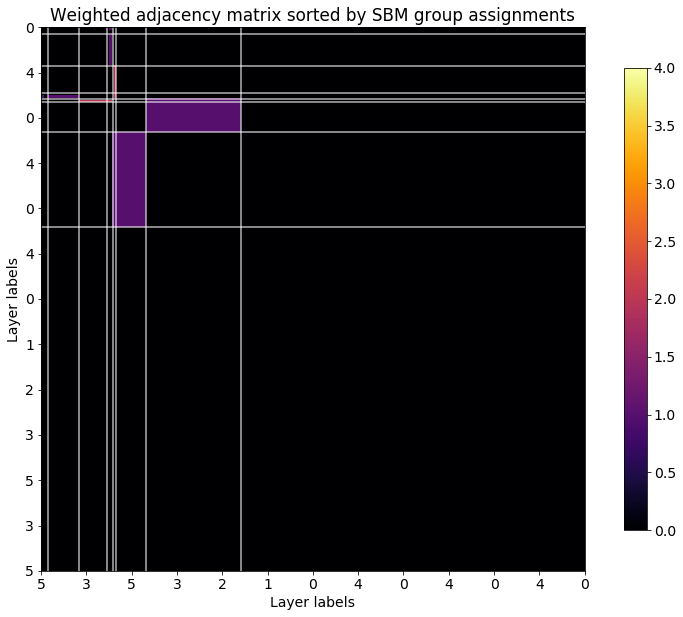

In [108]:
def compress_node_labels(labels):
    compressed_labels = [labels[0]]
    for i in range(1, len(labels)):
        if labels[i] != compressed_labels[-1]:
            compressed_labels.append(labels[i])
    return compressed_labels
groups = sbm_0.get_bs()[0]
order = np.array(np.argsort(np.argsort(groups)))
g_adj_sorted = sort_adj_matrix(order, g_adj)
node_names = sort_nodes(order, np.array(g_xs[0].vp.layer.a))
ordered_groups = sort_nodes(order, groups)
fig, ax = plt.subplots(figsize=(14,10))
im = ax.imshow(g_adj_sorted, cmap='inferno')
plt.colorbar(im, ax=ax, shrink=0.85)
node_names_compressed = compress_node_labels(node_names)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xticks(np.linspace(xlim[0], xlim[1], len(node_names_compressed)))
ax.set_yticks(np.linspace(ylim[0], ylim[1], len(node_names_compressed)))
ax.set_xticklabels(node_names_compressed)
ax.set_yticklabels(node_names_compressed)
plot_all_boundaries(get_partition_boundaries(ordered_groups), ax)
plt.xlabel('Layer labels')
plt.ylabel('Layer labels')
plt.title('Weighted adjacency matrix sorted by SBM group assignments')
plt.show()

In [80]:
node_names_compressed

[5, 3, 5, 3, 2, 1, 0, 4, 0, 4, 0, 4, 0]

In [109]:
mnist.test_labels[rand_inds[0]]

0